Funcion objetivo:

Maximizar z = 70x1 + 91x2 + 50x2 + 61x4 + 21x5

Minimizar z = 170x1 + 310x2 + 60x3 + 101x4 + 11x5

sujeto a:

      x1 ≤ 15
      x2 ≤ 10
      x3 ≤ 25
      x4 ≤ 4
      x5 ≤ 30
      
      170x1 + 310x2 ≤ 3800
      60x3 + 101x4 ≤ 2800
      101x4 + 11x5 ≤ 3500

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

Nodo y Arco Consistencia


In [2]:
# Nodo Consistencia
domains = {
    'x1': [i for i in range(0,16)],
    'x2': [i for i in range(0,11)],
    'x3': [i for i in range(0,26)],
    'x4': [i for i in range(0,5)],
    'x5': [i for i in range(0,31)],
}

In [3]:
# Restricciones
constraints = {

    ('x1', 'x2'): lambda x1, x2:  170*x1 <= 3800-310*x2,
    ('x2', 'x1'): lambda x2, x1:  3800-310*x2 >= 170*x1,

    ('x3', 'x4'): lambda x3, x4:  60*x3 <= 2800-101*x4,
    ('x4', 'x3'): lambda x4, x3:  2800-101*x4 >= 60*x3,

    ('x3', 'x5'): lambda x3, x5:  60*x3 <= 3500-11*x5,
    ('x5', 'x3'): lambda x5, x3:  3500-11*x5 >= 60*x3,

}

In [4]:
# Implementación de AC3
def revise(x, y):
    revised = False
    x_domain = domains[x]
    y_domain = domains[y]
    all_constraints = [
        constraint for constraint in constraints if constraint[0] == x and constraint[1] == y]
    for x_value in x_domain:
        satisfies = False
        for y_value in y_domain:
            for constraint in all_constraints:
                constraint_func = constraints[constraint]
                if constraint_func(x_value, y_value):
                    satisfies = True
        if not satisfies:
            x_domain.remove(x_value)
            revised = True
    return revised

def ac3(arcs):
    queue = arcs[:]
    while queue:
        (x, y) = queue.pop(0)
        revised = revise(x, y)
        if revised:
            neighbors = [neighbor for neighbor in arcs if neighbor[1] == x]
            queue = queue + neighbors


In [ ]:
# Arcos de las restricciones del problema
arcs = [
    ('x1','x2'), ('x2','x1'),
    ('x3','x4'), ('x4','x3'),
    ('x3', 'x5'), ('x5','x3')
]

ac3(arcs)

print("x1: " + str(domains['x1']))
print("x2: " + str(domains['x2']))
print("x3: " + str(domains['x3']))
print("x4: " + str(domains['x4']))
print("x5: " + str(domains['x5']))

In [36]:
class Problema:
  def __init__(self, epsilon):
    self.epsilon = epsilon
    self.dimensiones = 5
    self.limites = {
      'x1': (0, 15),
      'x2': (0, 10),
      'x3': (0, 25),
      'x4': (0, 4),
      'x5': (0, 30)
    }

    self.costos = {
      'x1': 170,
      'x2': 310,
      'x3': 60,
      'x4': 101,
      'x5': 11
    }

    self.presMaxTv = 3800
    self.presMaxDyR = 2800
    self.presMaxDyR = 3500

  def check(self, x):
    # Chequeo de restricciones de presupuesto
    costo_tv = self.costos['x1'] * x[0] + self.costos['x2'] * x[1]
    costo_print = self.costos['x3'] * x[2] + self.costos['x4'] * x[3]
    costo_combined = self.costos['x3'] * x[2] + self.costos['x5'] * x[4]
        
    if costo_tv > self.presMaxTv:
      return False
    if costo_print > self.presMaxDyR:
      return False
    if costo_combined > self.presMaxDyR:
      return False

    # Chequeo de límites de cantidad de anuncios
    for i, (c_min, c_max) in enumerate(self.limites.values()):
      if not (c_min <= x[i] <= c_max):
        return False

    # Chequeo de epsilon-constraint
    totalCosto = 170 * x[0] + 310 * x[1] + 60 * x[2] + 101 * x[3] + 11 * x[4]
    if totalCosto > self.epsilon:
      return False

    return True
  
  def checkCostos(self, x):
    totalCosto = 170 * x[0] + 310 * x[1] + 60 * x[2] + 101 * x[3] + 11 * x[4]
    return totalCosto
  
  def checkQuality(self, x):
     totalQuality = 70 * x[0] + 91 * x[1] + 50 * x[2] + 61 * x[3] + 21 * x[4]
     return totalQuality

  def eval(self, x):

    # Se evalua el fitness utilizando la nueva funcion
    #return self.scalarazing(x)

    # Se evalua el fitness
    return 70 * x[0] + 91 * x[1] + 50 * x[2] + 61 * x[3] + 21 * x[4]
  

  def sigmoide(self, x, alpha, x0):
    return 1/(1+np.exp(-alpha*(x-x0)))
  
  def find_y_interval(self, y, intervals):
    interval_width = 1 / intervals
    for i in range(intervals):
        if i * interval_width <= y < (i + 1) * interval_width:
            return i
    return intervals - 1 if y == 1 else None
  
  def master_sigmoide(self, arreglo):
    parameters = [
      (0.6, 7.5, 16),    
      (1, 5, 11),        
      (0.35, 12.5, 26),  
      (2.5, 2, 5),       
      (0.3, 15, 31)      
    ]
    
    results_list = []  # Use a Python list for appending
    for x, (alpha, x0, intervals) in zip(arreglo, parameters):
        y = self.sigmoide(x, alpha, x0)
        if intervals == 5: 
            if 0 <= y < 0.2:
                results_list.append(0)
            elif 0.2 <= y < 0.4:
                results_list.append(1)
            elif 0.4 <= y < 0.6:
                results_list.append(2)
            elif 0.6 <= y < 0.8:
                results_list.append(3)
            elif 0.8 <= y <= 1:
                results_list.append(4)
            else:
                results_list.append(None)
        else:
            results_list.append(self.find_y_interval(y, intervals))
    
    return np.array(results_list)  # Convert the list to a NumPy array before returning
  

In [7]:
class Particula:
  def __init__(self, problema):
    self.problema = problema
    self.x = np.zeros(problema.dimensiones)
    self.inicializacion()


  def inicializacion(self):
    for j in range(self.problema.dimensiones):
      c_min, c_max = list(self.problema.limites.values())[j]
      self.x[j] = (c_min + random.random() * (c_max - c_min))

  def esFactible(self, x):
    # Codigo
    return self.problema.check(self.x)

  def esMejorQue(self, comp):
    # Codigo
    return self.fit() > comp.fit()

  def fit(self):
    # Codigo
    return self.problema.eval(self.x)

  def __str__(self):
    # Representación en cadena de la partícula
    return f"fit:{self.fit()} x:{self.x}"


In [8]:
class EquilibriumOptimizer1:
    def __init__(self, problema, n, MAX_ITER, a1, a2, GP):
        self.problema = problema
        self.nParticulas = n
        self.maxIter = MAX_ITER
        self.a1 = a1
        self.a2 = a2
        self.GP = GP
        self.V = 1
        self.enjambre = []
        self.eq_candidatos = [Particula(problema) for _ in range(n)]

        self.lower_band = [ self.problema.limites[f"x{i+1}"][0] for i in range( len( self.problema.limites.keys() ) ) ]
        self.upper_band = [ self.problema.limites[f"x{i+1}"][-1] for i in range( len( self.problema.limites.keys() ) ) ]


    def inicializarPoblacion(self):
        for _ in range(self.nParticulas):
            while True:
                particula = Particula(self.problema)
                if particula.esFactible(particula.x):
                    self.enjambre.append(particula)
                    break
    
    def updateCandidatosEq(self):
        for particula in self.enjambre:

            if particula.esMejorQue(self.eq_candidatos[0]):
                self.eq_candidatos = [particula] + self.eq_candidatos[:-1]

            elif particula.esMejorQue(self.eq_candidatos[1]):
                self.eq_candidatos = [self.eq_candidatos[0], particula] + self.eq_candidatos[1:-1]

            elif particula.esMejorQue(self.eq_candidatos[2]):
                self.eq_candidatos = self.eq_candidatos[:2] + [particula] + self.eq_candidatos[2: -1]
            
            elif particula.esMejorQue(self.eq_candidatos[3]):
                self.eq_candidatos[3] = particula
                
    def construirEqPool(self):
        eqPromedio = Particula(self.problema)
        eqPromedio.x = np.mean([ candidato.x for candidato in self.eq_candidatos ], axis = 0).tolist()
        return self.eq_candidatos + [ eqPromedio ]
    
    def evolucion(self):

        for iter in range(1, self.maxIter + 1):

            print(f"Iteracion no: {iter}")
            
            self.updateCandidatosEq()
            eq_pool = self.construirEqPool()
            for particula in eq_pool:
                print(particula)

            # Calcular t segun Eq. (9)
            t = (1 - iter / self.maxIter) ** ( self.a2 * iter/self.maxIter )

            for particula in self.enjambre:

                eq_candidato = random.choice(eq_pool)                        # Eleccion randomica de un candidato del eq_pool
                vectorLambda = np.random.rand(self.problema.dimensiones)     # Valor randomico del 0 al 1 para la Eq. (11)
                vectorR = np.random.rand(self.problema.dimensiones)          # valor randomico del 0 al 1 para la Eq. (11)

                # Eq. (11)
                F = self.a1 * np.sign(vectorR - 0.5) * ( np.exp(-vectorLambda * t) - 1 )

                # Eq. (15)
                GCP = np.where( np.random.rand(self.problema.dimensiones) >= self.GP , 0.5 * random.random(), 0 )

                # Eq. (14)
                G0 = GCP * ( eq_candidato.x - vectorLambda * particula.x )

                # Eq. (13)
                G = G0 * F

                # Eq. (16)
                particula.x = eq_candidato.x + ( (particula.x - eq_candidato.x) * F )  + (G / vectorLambda) * (1 - F)
        
                # np.clip
                particula.x = np.clip(particula.x, self.lower_band, self.upper_band)

                particula.x = np.where(particula.x % 1 == 0, particula.x, np.round(particula.x))
                
    def solve(self):
        self.inicializarPoblacion()
        self.evolucion()
        self.updateCandidatosEq()
        mejoresParticulas = self.eq_candidatos
        print("Mejores particulas: ")
        for particula in mejoresParticulas:
            print(particula)


In [32]:
class EquilibriumOptimizer2:
    def __init__(self, problema, n, MAX_ITER, a1, a2, GP):
        self.problema = problema
        self.nParticulas = n
        self.maxIter = MAX_ITER
        self.a1 = a1
        self.a2 = a2
        self.GP = GP
        self.V = 1
        self.enjambre = []
        self.eq_candidatos = [Particula(problema) for _ in range(4)]

        self.lower_band = [ self.problema.limites[f"x{i+1}"][0] for i in range( len( self.problema.limites.keys() ) ) ]
        self.upper_band = [ self.problema.limites[f"x{i+1}"][-1] for i in range( len( self.problema.limites.keys() ) ) ]


    def inicializarPoblacion(self):
        print("Creacion de particulas: \n")
        for _ in range(self.nParticulas):
            while True:
                particula = Particula(self.problema)
                particula.x = self.problema.master_sigmoide(particula.x)
                print(particula.x)
                if particula.esFactible(particula.x):
                    self.enjambre.append(particula)
                    break
    
    def updateCandidatosEq(self):
        for particula in self.enjambre:
            for i in range(len(self.eq_candidatos)):
                if particula.esMejorQue(self.eq_candidatos[i]):
                    self.eq_candidatos[i] = particula
                    break
                
    def construirEqPool(self):
        eqPromedio = Particula(self.problema)
        eqPromedio.x = np.mean([ candidato.x for candidato in self.eq_candidatos ], axis = 0).tolist()
        eqPromedio.x = self.problema.master_sigmoide(eqPromedio.x)
        return self.eq_candidatos + [ eqPromedio ]
    
    def evolucion(self):

        for iter in range(1, self.maxIter + 1):
            
            self.updateCandidatosEq()
            eq_pool = self.construirEqPool()

            # Calcular t segun Eq. (9)
            t = (1 - iter / self.maxIter) ** ( self.a2 * iter/self.maxIter )

            for particula in self.enjambre:

                while True:

                    eq_candidato = random.choice(eq_pool)                        # Eleccion randomica de un candidato del eq_pool
                    vectorLambda = np.random.rand(self.problema.dimensiones)     # Valor randomico del 0 al 1 para la Eq. (11)
                    vectorR = np.random.rand(self.problema.dimensiones)          # valor randomico del 0 al 1 para la Eq. (11)

                    # Eq. (11)
                    F = self.a1 * np.sign(vectorR - 0.5) * ( np.exp(-vectorLambda * t) - 1 )

                    # Eq. (15)
                    GCP = np.where( np.random.rand(self.problema.dimensiones) >= self.GP , 0.5 * random.random(), 0 )

                    # Eq. (14)
                    G0 = GCP * ( eq_candidato.x - vectorLambda * particula.x )

                    # Eq. (13)
                    G = G0 * F

                    # Eq. (16)
                    particula.x = eq_candidato.x + ( (particula.x - eq_candidato.x) * F )  + (G / vectorLambda) * (1 - F)

                    particula.x = self.problema.master_sigmoide(particula.x)
                    
                    # np.clip
                    #particula.x = np.clip(particula.x, self.lower_band, self.upper_band)

                    if (particula.esFactible(particula.x)):
                        #print("particula era factible")
                        break
    
    def solve(self):
        self.inicializarPoblacion()
        self.evolucion()
        self.updateCandidatosEq()

In [ ]:
# Cantidad de particulas = 5
#n = 30
# Numero maximo de iteraciones
#MAX_ITER = 5
# Constantes de explotacion y explotacion
#a1 = 2
#a2 = 1
#
#GP = 0.5

# Ejecutar el optimizador
#problema = Problema(epsilon=4000)
#optimizer = EquilibriumOptimizer2(problema, n, MAX_ITER, a1, a2, GP)
#optimizer.solve()



In [91]:
# a1 = parametro de exploracion
# a2 = parametro de explotacion
# GP = 0.5 por defecto (Segun pruebas empiricas del paper, es el valor optimo entre exploracion y explotacion)

configuraciones = [
    
    {'a1': 2, 'a2': 1}, # Valores por defecto
    {'a1': 1, 'a2': 1},
    {'a1': 0.5, 'a2': 1},

    {'a1': 2, 'a2': 2},
    {'a1': 1, 'a2': 0.5,}
    
]

epsilon = 3000 # 3000, 4000, 5000

import pandas as pd

# Registro de resultados
results = []
for configuration in configuraciones:
    problema = Problema(epsilon)
    a1 = configuration['a1']
    a2 = configuration['a2']
    GP = 0.5  # Valor fijo
    print(f"Parametros: a1={a1}, a2={a2}")
    optimizer = EquilibriumOptimizer2(problema, n=100, MAX_ITER=3, a1=a1, a2=a2, GP=GP) # n = cantidad de particulas, MAX_ITER = cantidad de iteraciones
    optimizer.solve()
    optimizer.updateCandidatosEq()

    results = []
    for particula in optimizer.enjambre:
        results.append({
            'x': particula.x.tolist(),
            'fit': particula.fit(),
            'Maximizacion': particula.problema.checkQuality(particula.x),
            'Minimizacion': particula.problema.checkCostos(particula.x),
            'Factibilidad': particula.esFactible(particula.x),
            'a1': a1,
            'a2': a2,
            'epsilonConstraint': epsilon
        })
    
    # Convertir resultados a DataFrame
    df = pd.DataFrame(results)
    
    filename = f'resultados_experimentos_e_{epsilon}_a1_{a1}_a2_{a2}.csv'
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")


Parametros: a1=2, a2=1
Creacion de particulas: 

[ 1  3 25  0 21]
[ 4  3 16  0 13]
[11 10  0  4 23]
[ 0  0 22  4 29]
[14 10 21  0 21]
[12  6  6  4 25]
[13  0  0  4  0]
[ 1  4  0  4 15]
[ 4  0 12  2 13]
[15  1  5  0 30]
[10  8 19  2  7]
[15  0  1  0  8]
[15  0  0  0  3]
[0 3 8 0 2]
[ 1  3 25  0  2]
[15 10 22  0  7]
[15  0 24  4 18]
[12  9 22  4 30]
[ 0  4 24  2  8]
[12  4 10  3  0]
[ 0  8 22  2 30]
[12  0  0  0 27]
[15 10  2  4 14]
[15  0 25  1  8]
[ 0 10  1  0  0]
[ 8 10 24  0 29]
[6 1 1 3 0]
[ 1 10  1  2  1]
[15  2 14  2  9]
[ 0 10 25  1 22]
[15 10 21  4 30]
[ 2 10  1  0 28]
[ 1  1  1  2 29]
[ 7  0 10  4  0]
[ 8  5  0  1 29]
[15  0 10  0 30]
[15 10  0  0 26]
[ 3 10 25  0  7]
[ 1  0  2  0 30]
[15  1  6  0  0]
[ 5 10 24  4 18]
[ 0  0 25  4 20]
[ 2  8  3  0 30]
[ 0 10  8  4 24]
[ 2  7  2  4 26]
[15  0  0  0 13]
[ 2  1 25  3  0]
[ 9  1  3  0 26]
[13  1 25  0 30]
[12 10  0  0  4]
[11  0 18  0 28]
[1 6 2 4 3]
[5 8 1 0 0]
[15 10 10  0  0]
[14  0 21  0 22]
[ 0  4 19  0 29]
[ 6  6  5  4 29]
[ 

KeyboardInterrupt: 

In [70]:
import pandas as pd
import os
import re
from rich.console import Console
from rich.table import Table

# Obtener la lista de archivos CSV en el directorio actual
directory = os.getcwd()
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Crear una consola para la salida con rich
console = Console()

# Inicializar un diccionario para almacenar los resultados
resultados = {}

# Expresión regular para extraer los valores de epsilon, a1 y a2 de los nombres de los archivos
pattern = re.compile(r'resultados_experimentos_e_(\d+)_a1_(\d+\.?\d*)_a2_(\d+\.?\d*)\.csv')

for file in csv_files:
    match = pattern.match(file)
    if match:
        epsilon, a1, a2 = match.groups()
        
        # Convertir los valores a los tipos adecuados
        epsilon = int(epsilon)
        a1 = float(a1)
        a2 = float(a2)
        
        # Leer el archivo CSV
        filepath = os.path.join(directory, file)
        df = pd.read_csv(filepath)
        
        # Inicializar un diccionario para los resultados de este epsilon si no existe
        if epsilon not in resultados:
            resultados[epsilon] = {}
        
        # Inicializar una lista para almacenar los resultados de esta combinación de a1 y a2
        key = f"{a1}-{a2}"
        if key not in resultados[epsilon]:
            resultados[epsilon][key] = []
        
        # Agregar los datos a los resultados
        for _, row in df.iterrows():
            resultados[epsilon][key].append(row)
        
        # Crear una tabla con rich
        tabla = Table(title=f"Resultados para epsilon {epsilon} con a1={a1} y a2={a2}", show_header=True, header_style="white")
        tabla.add_column("x", justify="full", no_wrap=True)
        tabla.add_column("fit", justify="full", no_wrap=True)
        tabla.add_column("Maximizacion", style="dim", justify="full", no_wrap=True)
        tabla.add_column("Minimizacion", style="dim", justify="full")
        tabla.add_column("Factibilidad", style="dim", justify="full")

        for _, row in df.iterrows():
            x = row['x']
            fit = row['fit']
            maximizacion = row['Maximizacion']
            minimizacion = row['Minimizacion']
            factibilidad = row['Factibilidad']
            
            # Agregar los datos a la tabla
            tabla.add_row(str(x), str(fit), str(maximizacion), str(minimizacion), str(factibilidad))
        
        # Imprimir la tabla con rich
        console.print(tabla)

# Los resultados ahora están organizados en el diccionario `resultados`

            Resultados para epsilon 3000 con a1=0.5 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
└───

            Resultados para epsilon 3000 con a1=1.0 y a2=0.5             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
└───

            Resultados para epsilon 3000 con a1=1.0 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
└───

            Resultados para epsilon 3000 con a1=2.0 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [2, 0, 25, 4, 29] │ 2243 │ 2243         │ 2563         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
└───

            Resultados para epsilon 3000 con a1=2.0 y a2=2.0             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [2, 0, 25, 0, 30] │ 2020 │ 2020         │ 2170         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│ [6, 0, 25, 0, 29] │ 2279 │ 2279         │ 2839         │ True         │
│ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
└───

            Resultados para epsilon 4000 con a1=2.0 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
│ [9, 0, 25, 4, 30] │ 2754 │ 2754         │ 3764         │ True         │
└───

             Resultados para epsilon 5000 con a1=0.5 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 31

             Resultados para epsilon 5000 con a1=1.0 y a2=0.5             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 31

             Resultados para epsilon 5000 con a1=1.0 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│ [15, 0, 25, 0, 30] │ 29

             Resultados para epsilon 5000 con a1=2.0 y a2=1.0             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 31

             Resultados para epsilon 5000 con a1=2.0 y a2=2.0             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│ [15, 0, 25, 4, 30] │ 31

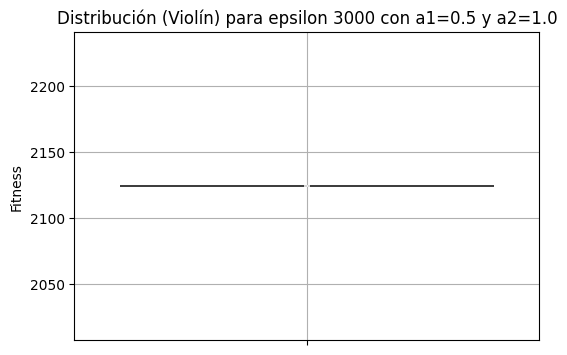

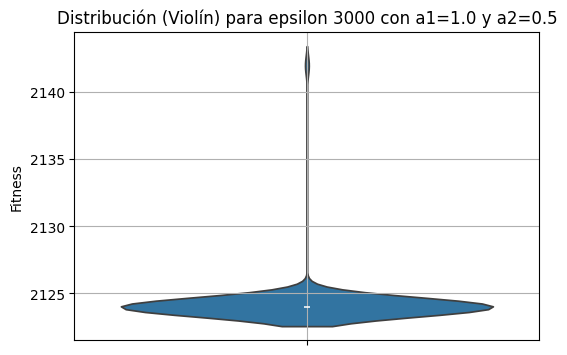

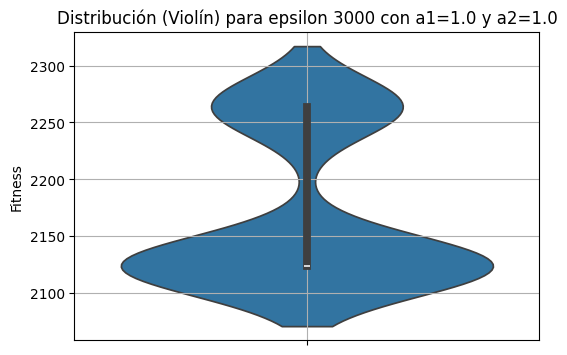

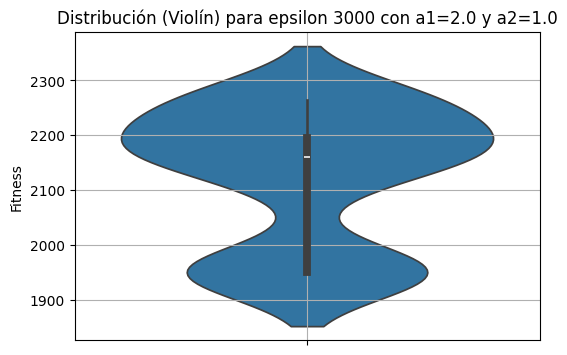

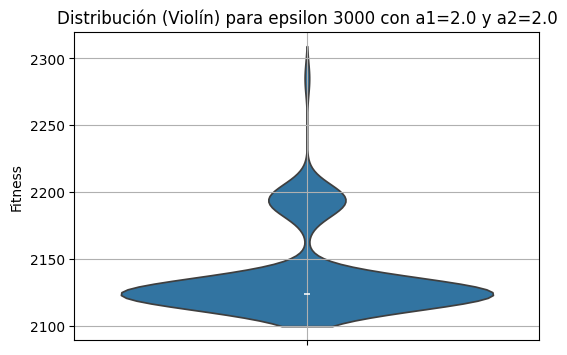

Resumen Descriptivo para epsilon
    3000 con a1=0.5 y a2=1.0    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 2124.0 │
│ Peor Fitness        │ 2124.0 │
│ Promedio            │ 2124.0 │
│ Mediana             │ 2124.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

Resumen Descriptivo para epsilon 
    3000 con a1=1.0 y a2=0.5     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Métrica             ┃ Valor   ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Mejor Fitness       │ 2142.0  │
│ Peor Fitness        │ 2124.0  │
│ Promedio            │ 2124.18 │
│ Mediana             │ 2124.0  │
│ Desviación Estándar │ 1.8     │
└─────────────────────┴─────────┘

 Resumen Descriptivo para epsilon 3000 con 
              a1=1.0 y a2=1.0              
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Métrica             ┃ Valor             ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness       │ 2264.0            │
│ Peor Fitness        │ 2124.0            │
│ Promedio            │ 2171.6            │
│ Mediana             │ 2124.0            │
│ Desviación Estándar │ 66.65333199973328 │
└─────────────────────┴───────────────────┘

 Resumen Descriptivo para epsilon 3000 con  
              a1=2.0 y a2=1.0               
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica             ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness       │ 2264.0             │
│ Peor Fitness        │ 1950.0             │
│ Promedio            │ 2126.9             │
│ Mediana             │ 2160.0             │
│ Desviación Estándar │ 123.50025559209637 │
└─────────────────────┴────────────────────┘

 Resumen Descriptivo para epsilon 3000 con  
              a1=2.0 y a2=2.0               
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica             ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness       │ 2285.0             │
│ Peor Fitness        │ 2124.0             │
│ Promedio            │ 2137.51            │
│ Mediana             │ 2124.0             │
│ Desviación Estándar │ 30.313011840935356 │
└─────────────────────┴────────────────────┘

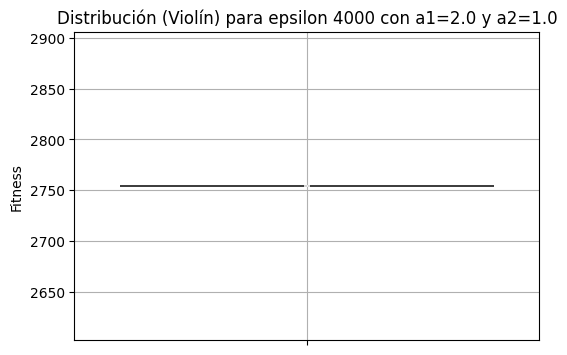

Resumen Descriptivo para epsilon
    4000 con a1=2.0 y a2=1.0    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 2754.0 │
│ Peor Fitness        │ 2754.0 │
│ Promedio            │ 2754.0 │
│ Mediana             │ 2754.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

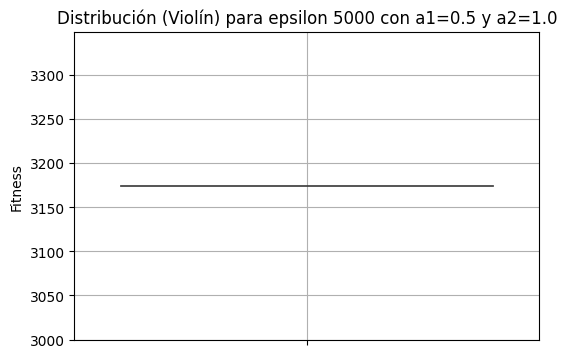

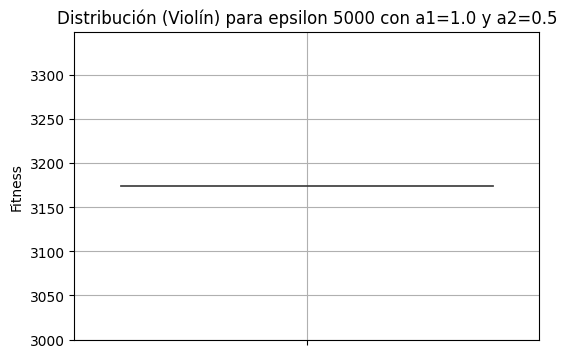

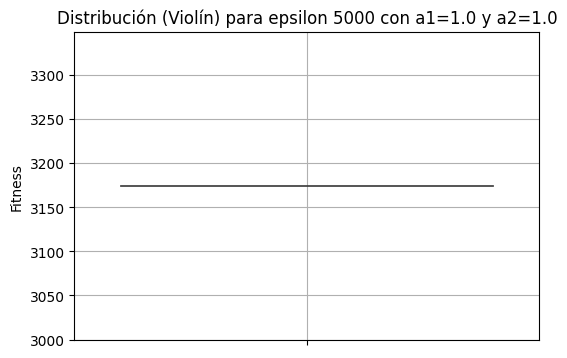

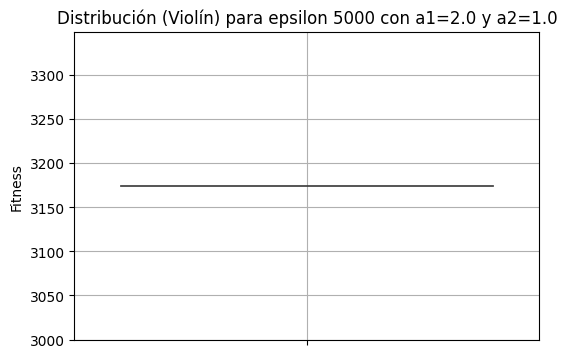

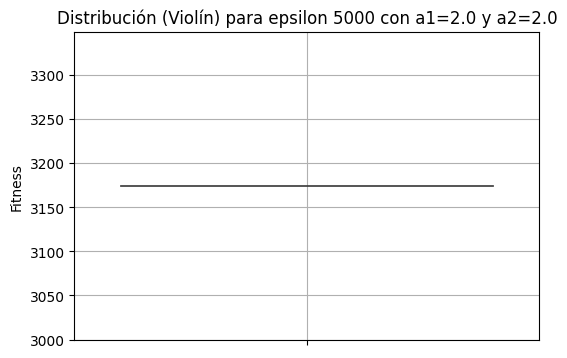

Resumen Descriptivo para epsilon
    5000 con a1=0.5 y a2=1.0    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 3174.0 │
│ Peor Fitness        │ 3174.0 │
│ Promedio            │ 3174.0 │
│ Mediana             │ 3174.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

Resumen Descriptivo para epsilon
    5000 con a1=1.0 y a2=0.5    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 3174.0 │
│ Peor Fitness        │ 3174.0 │
│ Promedio            │ 3174.0 │
│ Mediana             │ 3174.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

Resumen Descriptivo para epsilon
    5000 con a1=1.0 y a2=1.0    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 3174.0 │
│ Peor Fitness        │ 3174.0 │
│ Promedio            │ 3174.0 │
│ Mediana             │ 3174.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

Resumen Descriptivo para epsilon
    5000 con a1=2.0 y a2=1.0    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 3174.0 │
│ Peor Fitness        │ 3174.0 │
│ Promedio            │ 3174.0 │
│ Mediana             │ 3174.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

Resumen Descriptivo para epsilon
    5000 con a1=2.0 y a2=2.0    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Métrica             ┃ Valor  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Mejor Fitness       │ 3174.0 │
│ Peor Fitness        │ 3174.0 │
│ Promedio            │ 3174.0 │
│ Mediana             │ 3174.0 │
│ Desviación Estándar │ 0.0    │
└─────────────────────┴────────┘

In [92]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.table import Table

# Directorio donde están los archivos CSV
directory = os.getcwd()
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Crear una consola para la salida con rich
console = Console()

# Inicializar un diccionario para almacenar los datos
data_dict = {}

# Expresión regular para extraer los valores de epsilon, a1 y a2 de los nombres de los archivos
pattern = re.compile(r'resultados_experimentos_e_(\d+)_a1_(\d+\.?\d*)_a2_(\d+\.?\d*)\.csv')

for file in csv_files:
    match = pattern.match(file)
    if match:
        epsilon, a1, a2 = match.groups()
        
        # Convertir los valores a los tipos adecuados
        epsilon = int(epsilon)
        a1 = float(a1)
        a2 = float(a2)
        
        # Leer el archivo CSV
        filepath = os.path.join(directory, file)
        df = pd.read_csv(filepath)
        
        # Inicializar un diccionario para los datos de este epsilon si no existe
        if epsilon not in data_dict:
            data_dict[epsilon] = {}
        
        # Inicializar un DataFrame para esta combinación de a1 y a2
        key = f"{a1}-{a2}"
        if key not in data_dict[epsilon]:
            data_dict[epsilon][key] = pd.DataFrame()
        
        data_dict[epsilon][key] = pd.concat([data_dict[epsilon][key], df])

# Función para generar la tabla de resumen descriptivo
def generar_resumen_descriptivo(df):
    resumen = {
        'Mejor Fitness': df['fit'].max(),
        'Peor Fitness': df['fit'].min(),
        'Promedio': df['fit'].mean(),
        'Mediana': df['fit'].median(),
        'Desviación Estándar': df['fit'].std(),
        # 'Rango Intercuartílico': iqr(df['fit'])
    }
    return pd.Series(resumen)

# Generar los resúmenes descriptivos y visualizaciones agrupados por epsilon
for epsilon, grupos in data_dict.items():
    # Crear un contenedor para las tablas
    tablas = []
    
    for key, df in grupos.items():
        a1, a2 = key.split('-')
        a1, a2 = float(a1), float(a2)
        
        # Generar resumen descriptivo
        resumen = generar_resumen_descriptivo(df)
        
        # Crear tabla con rich
        tabla = Table(title=f"Resumen Descriptivo para epsilon {epsilon} con a1={a1} y a2={a2}", show_header=True, header_style="bold magenta")
        tabla.add_column("Métrica", justify="full", no_wrap=True)
        tabla.add_column("Valor", justify="full", no_wrap=True)

        for metrica, valor in resumen.items():
            tabla.add_row(metrica, str(valor))
        
        tablas.append(tabla)
        
        # Gráfico de violín
        plt.figure(figsize=(6, 4))
        sns.violinplot(data=df, y='fit')
        plt.title(f"Distribución (Violín) para epsilon {epsilon} con a1={a1} y a2={a2}")
        plt.ylabel("Fitness")
        plt.grid(True)
        plt.show()
    
    # Imprimir todas las tablas juntas para este epsilon
    for tabla in tablas:
        console.print(tabla)


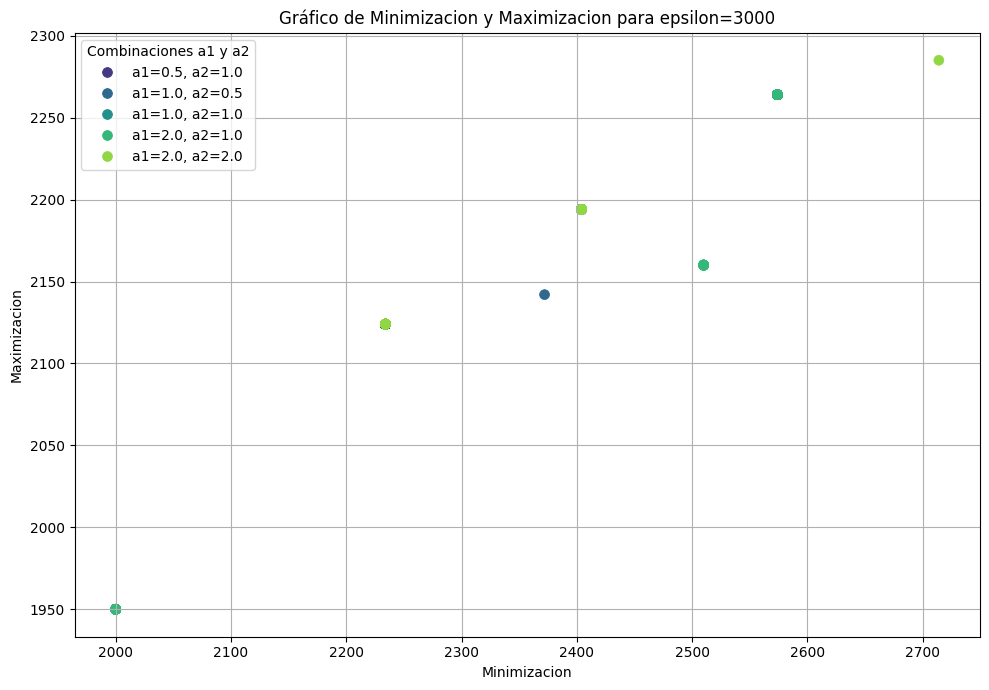

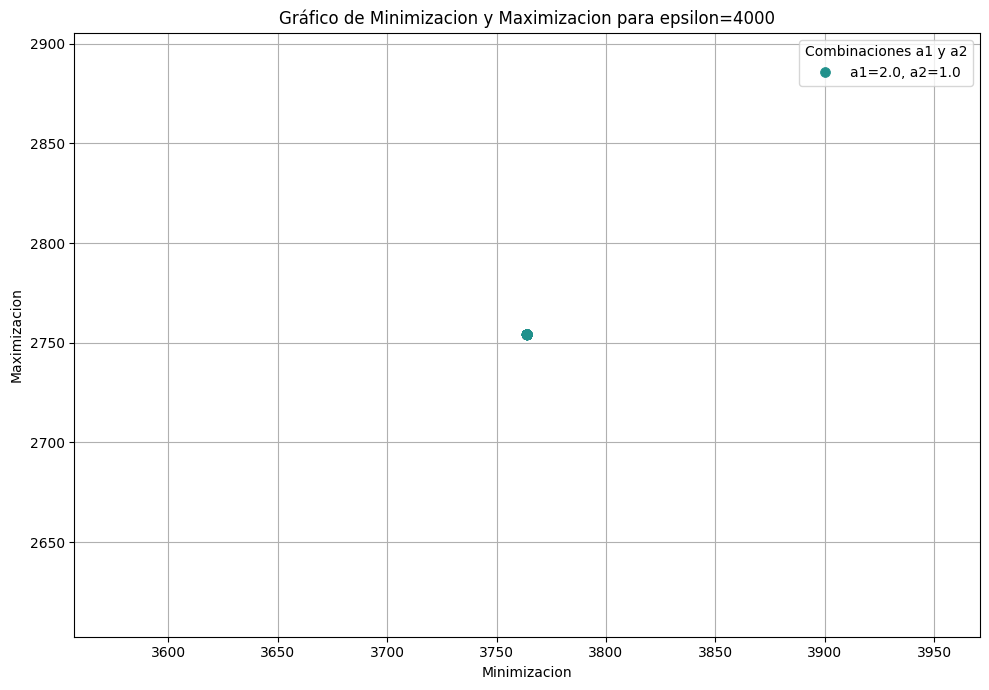

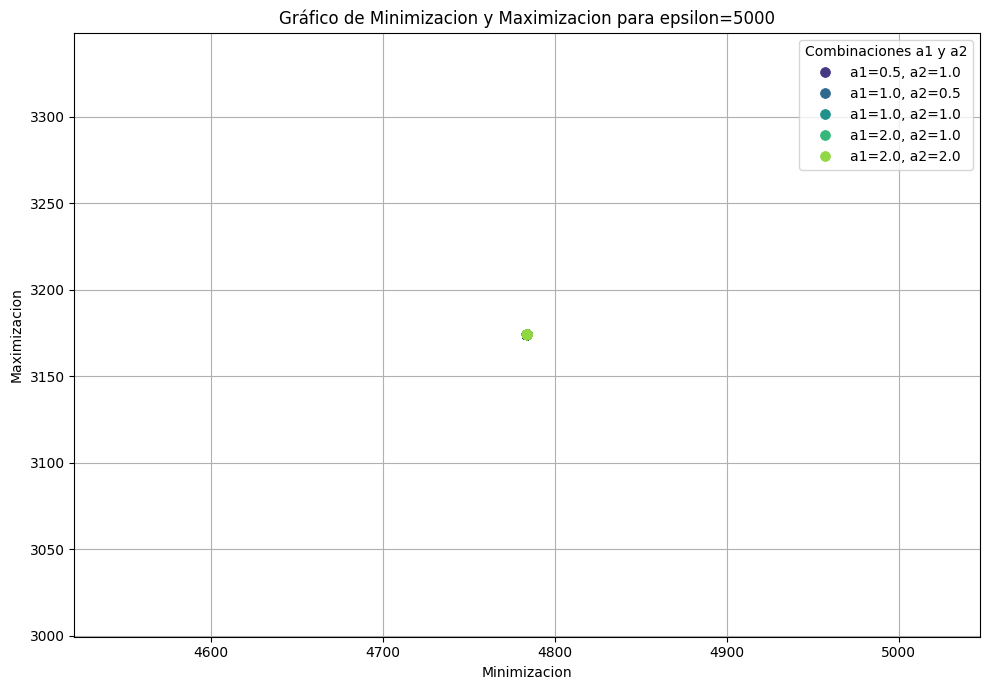

In [94]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Directorio donde están los archivos CSV
directory = os.getcwd()
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Inicializar un diccionario para almacenar los datos
data_dict = {}

# Expresión regular para extraer los valores de epsilon, a1 y a2 de los nombres de los archivos
pattern = re.compile(r'resultados_experimentos_e_(\d+)_a1_(\d+\.?\d*)_a2_(\d+\.?\d*)\.csv')

# DataFrame para almacenar todos los puntos
all_data = pd.DataFrame()

for file in csv_files:
    match = pattern.match(file)
    if match:
        epsilon, a1, a2 = match.groups()
        
        # Convertir los valores a los tipos adecuados
        epsilon = int(epsilon)
        a1 = float(a1)
        a2 = float(a2)
        
        # Leer el archivo CSV
        filepath = os.path.join(directory, file)
        df = pd.read_csv(filepath)
        
        # Añadir columnas de parámetros
        df['epsilon'] = epsilon
        df['a1'] = a1
        df['a2'] = a2
        df['combinacion'] = f'a1={a1}, a2={a2}'
        
        # Concatenar al DataFrame general
        all_data = pd.concat([all_data, df], ignore_index=True)

# Generar gráficos por cada valor de epsilon
epsilons = all_data['epsilon'].unique()
for epsilon in epsilons:
    subset = all_data[all_data['epsilon'] == epsilon]
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=subset, x='Minimizacion', y='Maximizacion', hue='combinacion', palette='viridis', s=50, edgecolor=None)
    plt.title(f'Gráfico de Minimizacion y Maximizacion para epsilon={epsilon}')
    plt.xlabel('Minimizacion')
    plt.ylabel('Maximizacion')
    plt.legend(title='Combinaciones a1 y a2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
